# Preamble

In [ ]:
# Imports
## General
import numpy as np
import pickle as pkl
import json
import warnings
warnings.filterwarnings('ignore')
import gc
import os

## Data manipulation and preprocessing
import pandas as pd
import boto3
from sklearn.preprocessing import StandardScaler, FunctionTransformer,LabelEncoder, MinMaxScaler,OrdinalEncoder
#import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, MissingIndicator
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy import sparse
from tensorflow.keras.layers.experimental.preprocessing import StringLookup, Normalization

## Pre-processing functions
def criteo_log_transform(z):
    if z>2:
        return np.log(z)**2
    else:
        return z
def map_criteo_log_transform(x):
    return x.map(criteo_log_transform)

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image

## Modelling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from fastFM import sgd
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
from deepctr.models.fnn import FNN
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from deepctr.models.pnn import PNN
from deepctr.models.wdl import WDL
from deepctr.models.deepfm import DeepFM
from deepctr.models.autoint import AutoInt
from deepctr.models.fgcnn import FGCNN

# Introduction


The global digital advertising market is worth approximately \\$602 billion today. Due to the increasing rate of of online participation since the 
COVID-19 pandemic, this number has been rapidly increasing and is expected to reach \\$871 billion by the end of 2027 \citep{RefWorks:emarketer2023digital}.
Many of the of the major Ad platforms such as Google, Facebook and Amazon operate on a cost-per-user-engagement pricing model, which usually means that 
advertisers get charged for every time a user clicks on an advertisment. This means that these platforms are incentivized to make sure that the content 
shown to each user is as relevent as possible in order to maximize the number of clicks in the long term. Attaining accurate Click-Through Rate (CTR) 
prediction is a necessary first step for Ad persionalization, which is why study of CTR prediction methods have been an extremely active part of 
Machine Learning research over the past through years.

Initially, shallow prediction methods such as Logistic Regression, Factorization Machines \citep{RefWorks:rendle2010factorization} and Field-Aware Factorization 
Machines \citep{RefWorks:juan2016field-aware} have been used for CTR prediction. However, these methods have often been shown to be unable to capture the 
higher order feature interactions in the sparse multi-value categorical Ad Marketplace datasets \citep{RefWorks:zhang2021deep}. Since then, Deep Learning methods have been 
shown to show superior predictive ability on these datasets. The focus of my reasearch project is therefore to explore the merits of different Deep 
Learning architechtures for click-through rate prediction.

A number of Deep Learning models have been proposed for CTR prediction, some of which will be explored in this report. Each of these models
outperform their shallow counterparts in terms of predictive ability. In a static environment, these models are able to serve the CTR prediction
function of Ad personalization, but in a dynamic environment, the model must be able to adapt to the changing user preferences. This is where
Reinforcement Learning comes in. Reinforcement Learning is a type of Machine Learning that is used to make a sequence of decisions in an environment
in order to maximize some notion of cumulative reward. In the context of Ad personalization, the environment is composed of the user, the Ad platform
and the advertisments, whereas the reward is the users' engagement with the advertisments and with the Ad platform.


As outlined in the Feasibility secition of my Milestone 3 submission, I have segmented the work over the next few weeks according to the following timeline

![](figures/timeline.png)

Below I proceed by structuring my response according to the following sections
- Model Specific Research
- Data exploration, preprocessing and environment setup
- Model Replication and Experimentation

# Model Specific Research

In their review of Deep CTR prediction methods, (Gu, 2021) states that the objective of Click Through Rate prediction is to find function $f_\theta$ such that for a given set of features $x=\left(x_1,x_2,\ldots,x_n\right)\in R^n$ representing a user-session-placement instance, $f_\theta$ maps the feature space to the probability that the instance in question results in a click, i.e.:
$$
f_\theta\left(x\right)=CTR=\mathcal{P}\left(y=1\right)=\mathcal{P}\left(\mathrm{Click}\right)
$$


*__Fill out details from readings__*

On the basis of my reasearch and published results, I have chosen to investigate the following models:

__Shallow__
- Logistic Regression
- Factorization Machines

__Deep__
- Factorization Supported Neural Networks
- Product Based Neural Networks
- Wide and Deep
- DeepFM
- Feature Generation by Convolutional Neural Networks
- Automatic Feature Interaction (AutoInt)

# Data Exploration, Caching, Preprocessing pipeline

## Data Exploration

## Load benchmark datasets as tf.datasets

In [3]:
def list_files_in_folder(bucket_name, folder_name):
    out = []
    # Create a Boto3 client for S3
    s3_client = boto3.client('s3')
 
    response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=folder_name)
 
 
    if 'Contents' in response:
    
        for obj in response['Contents']:
            out.append(obj['Key'])
        out = out[1:]
        return out
    else:
        print("Folder is empty.")

### KDD12

In [4]:
# get avazu file names
bucket_name = 'mlds-final-project-bucket'
folder_name = 'kdd12/train/train_split/'
keys = list_files_in_folder(bucket_name, folder_name)
filenames = [f"s3://{bucket_name}/{key}" for key in keys]

In [5]:
# Load the kdd12_train dataset
kdd12_train = tf.data.experimental.make_csv_dataset(
    filenames,
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=['int32','int32','string','string','string','int32','int32','string','string','string','string','string'],
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

2024-08-04 09:29:53.041226: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-08-04 09:29:53.046186: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-04 09:29:53.055464: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
# get avazu file names
bucket_name = 'mlds-final-project-bucket'
folder_name = 'kdd12/train/test_split/'
keys = list_files_in_folder(bucket_name, folder_name)
filenames = [f"s3://{bucket_name}/{key}" for key in keys]

In [7]:
# Load the kdd12_train dataset
kdd12_val = tf.data.experimental.make_csv_dataset(
    filenames,
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=['int32','int32','string','string','string','int32','int32','string','string','string','string','string'],
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

### Avazu

In [8]:
# get avazu file names
bucket_name = 'mlds-final-project-bucket'
folder_name = 'avazu/train/train_split/'
keys = list_files_in_folder(bucket_name, folder_name)
filenames = [f"s3://{bucket_name}/{key}" for key in keys]

In [9]:
column_defaults=[
    'string',
    'int32',
    'int32',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string'
]
avazu_train = tf.data.experimental.make_csv_dataset(
    filenames,
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=column_defaults,
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

In [10]:
# get avazu file names
bucket_name = 'mlds-final-project-bucket'
folder_name = 'avazu/train/test_split/'
keys = list_files_in_folder(bucket_name, folder_name)
filenames = [f"s3://{bucket_name}/{key}" for key in keys]

In [11]:
column_defaults=[
    'string',
    'int32',
    'int32',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string',
    'string'
]

# Load the Avazu train dataset
avazu_val = tf.data.experimental.make_csv_dataset(
    filenames,
    batch_size=1,
    field_delim=',',
    header=True,
    column_defaults=column_defaults,
    label_name='click',
    num_epochs=1,
    shuffle=False,
    #shuffle_buffer_size=100,
    #shuffle_seed=42,
    #ignore_errors=True
)

In [12]:
# Drop ID variable
def drop_id(features, label):
    out_features = features.copy()
    del out_features['id']
    return out_features, label

In [13]:
avazu_train = avazu_train.map(drop_id)
avazu_val = avazu_val.map(drop_id)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### Criteo

In [14]:
# get criteo file names
bucket_name = 'mlds-final-project-bucket'
folder_name = 'dac/train/train_split/'
keys = list_files_in_folder(bucket_name, folder_name)
filenames = [f"s3://{bucket_name}/{key}" for key in keys]

In [15]:
# Load the Criteo train dataset

column_defaults = ['int32'] + 13*['int32'] + 26*['string']

criteo_train = tf.data.experimental.make_csv_dataset(
    filenames,
    batch_size=1,
    field_delim=',',
    header=True,
    label_name='click',
    column_defaults=column_defaults,
    num_epochs=1,
    shuffle=False,
    ignore_errors=True
)

In [16]:
# get criteo file names
bucket_name = 'mlds-final-project-bucket'
folder_name = 'dac/train/test_split/'
keys = list_files_in_folder(bucket_name, folder_name)
filenames = [f"s3://{bucket_name}/{key}" for key in keys]

In [17]:
# Load the Criteo train dataset

column_defaults = ['int32'] + 13*['int32'] + 26*['string']

criteo_val = tf.data.experimental.make_csv_dataset(
    filenames,
    batch_size=1,
    field_delim=',',
    header=True,
    label_name='click',
    column_defaults=column_defaults,
    num_epochs=1,
    shuffle=False,
    ignore_errors=True
)

I first perform an exploratory data analysis to show the type of preprocessing that needs to be made. In order to simplify the data processing requirements, I do this on the basis of $n=10000$ row samples of the data.

## Preprocessing

Below I construct the preprocessing pipeline for the tensorflow datasets on the basis of the exploration functions above. I proceed by:

- Enconding the sparse catecorically features using the Ordinal Encoders specified above.
- Standardizing the numerical features unsing the Scalers and Transformer specified above.
- Generating the feature columns, as specified in the [DeepCTR Quickstart Guide](https://deepctr-doc.readthedocs.io/en/latest/Quick-Start.html#step-3-generate-feature-columns)

In [18]:
## Create lists of categorical colums for each dataset
kdd12_categorical_columns = [
    'DisplayURL',
    'AdID',
    'AdvertiserID',
    'QueryID',
    'KeywordID',
    'TitleID',
    'DescriptionID',
    'UserID'
]

avazu_categorical_columns = [
    'C1',
    'banner_pos',
    'site_id',
    'site_domain',
    'site_category',
    'app_id',
    'app_domain',
    'app_category',
    'device_id',
    'device_ip',
    'device_model',
    'device_type',
    'device_conn_type',
    'C14',
    'C15',
    'C16',
    'C17',
    'C18',
    'C19',
    'C20',
    'C21'
]

criteo_numerical_columns = [f'int_{i}' for i in np.arange(1,14)]
criteo_categorical_columns = [f'cat_{i}' for i in np.arange(1,27)]

### Categorical Variable Encoding

In [19]:
# Import categorical feature mappings and define stringloohup objects for each dataset
kdd12_stringlookups = {}
for field in kdd12_categorical_columns:
    df = pd.read_csv(f'./data/kdd12/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    kdd12_stringlookups.update({field:lookup})

avazu_stringlookups = {}
for field in avazu_categorical_columns:
    df = pd.read_csv(f'./data/avazu/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    avazu_stringlookups.update({field:lookup})

criteo_stringlookups = {}
for field in criteo_categorical_columns:
    df = pd.read_csv(f'./data/criteo/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    criteo_stringlookups.update({field:lookup})

In [20]:
# Define categorical encoding function
@tf.function
def kdd12_categorical_encoding(features,label):
    # Create copy of features, because modifying inputs causes a ValueError
    out_features = features.copy()
    # Iteratively map the categical feature columns using the corresponging Lookup layer
    for f in kdd12_categorical_columns:
        lookup = kdd12_stringlookups[f]
        out_features[f.lower()] = lookup(features[f.lower()])
    return out_features, label

@tf.function
def avazu_categorical_encoding(features,label):
    # Create copy of features, because modifying inputs causes a ValueError
    out_features = features.copy()
    # Iteratively map the categical feature columns using the corresponging Lookup layer
    for f in avazu_categorical_columns:
        lookup = avazu_stringlookups[f]
        out_features[f] = lookup(features[f])
    return out_features, label

@tf.function
def criteo_categorical_encoding(features,label):
    # Create copy of features
    out_features = features.copy()
    # Iteratively map the categorical feature columns using the corresponding Lookup layer
    for f in criteo_categorical_columns:
        lookup = criteo_stringlookups[f]
        out_features[f] = lookup(features[f])
    return out_features, label

In [21]:
# Apply mapping over each dataset

kdd12_train_encoded = kdd12_train.map(kdd12_categorical_encoding)
avazu_train_encoded = avazu_train.map(avazu_categorical_encoding)
criteo_train_encoded = criteo_train.map(criteo_categorical_encoding)

kdd12_val_encoded = kdd12_val.map(kdd12_categorical_encoding)
avazu_val_encoded = avazu_val.map(avazu_categorical_encoding)
criteo_val_encoded = criteo_val.map(criteo_categorical_encoding)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

### Numerical Variable Scaling

In [22]:
# Define numerical feature columns
kdd12_numerical_columns = [
    'Depth',
    'Position',
    'Impression'
]

avazu_numerical_columns = [
    'hour'
]

criteo_numerical_columns = [f'int_{i}' for i in np.arange(1,14)]

In [23]:
# Extract scaler dicts for all datasets
dist_stats = pd.read_csv('./data/kdd12/means_variances.csv')
kdd12_scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    kdd12_scalers.update({field:scaler})

dist_stats = pd.read_csv('./data/avazu/means_variances.csv')
avazu_scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    avazu_scalers.update({field:scaler})

dist_stats = pd.read_csv('./data/criteo/means_variances.csv')
criteo_scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    criteo_scalers.update({field:scaler})

In [24]:
# Define scaler functions for all datasets

@tf.function
def kdd12_numerical_scaling(features,label):
    out_features = features.copy()
    for f in kdd12_numerical_columns:
        scaler = kdd12_scalers[f]
        out_features[f.lower()] = scaler(features[f.lower()])
    return out_features, label

@tf.function
def avazu_numerical_scaling(features,label):
    out_features = features.copy()
    for f in avazu_numerical_columns:
        scaler = avazu_scalers[f]
        out_features[f] = scaler(features[f])
    return out_features, label

@tf.function
def criteo_numerical_scaling(features,label):
    out_features = features.copy()
    for f in criteo_numerical_columns:
        scaler = criteo_scalers[f]
        out_features[f] = scaler(features[f])
    return out_features, label

In [25]:
# Apply the numerical scaling to all datasets
kdd12_train_scaled = kdd12_train_encoded.map(kdd12_numerical_scaling)
avazu_train_scaled = avazu_train_encoded.map(avazu_numerical_scaling)
criteo_train_scaled = criteo_train_encoded.map(criteo_numerical_scaling)

kdd12_val_scaled = kdd12_val_encoded.map(kdd12_numerical_scaling)
avazu_val_scaled = avazu_val_encoded.map(avazu_numerical_scaling)
criteo_val_scaled = criteo_val_encoded.map(criteo_numerical_scaling)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [26]:
# Print the element specs
print('KDD12:')
print(kdd12_train_scaled.element_spec)
print()
print('Avazu:')
print(avazu_train_scaled.element_spec)
print()
print('Criteo:')
print(criteo_train_scaled.element_spec)

KDD12:
(OrderedDict([('impression', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)), ('displayurl', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('adid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('advertiserid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('depth', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)), ('position', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)), ('keywordid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('titleid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('descriptionid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('queryid', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('userid', TensorSpec(shape=(None,), dtype=tf.int64, name=None))]), TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Avazu:
(OrderedDict([('hour', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)), ('C1', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('banner

In [27]:
# Apply log transformation to criteo datase

@tf.function
def criteo_log_scaling(features,label):
    out_features = features.copy()
    for f in criteo_numerical_columns:
        x = features[f]
        out_features[f] = tf.where(x>2,tf.math.square(tf.math.log(x)),x)
    return out_features, label

In [28]:
criteo_train_scaled = criteo_train_scaled.map(criteo_log_scaling)
criteo_val_scaled = criteo_val_scaled.map(criteo_log_scaling)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [29]:
# Define model inputs
kdd12_train_model_input = kdd12_train_scaled.take(157440).batch(256).prefetch(tf.data.AUTOTUNE)
avazu_train_model_input = avazu_train_scaled.take(157440).batch(256).prefetch(tf.data.AUTOTUNE)
criteo_train_model_input = criteo_train_scaled.take(157440).batch(256).prefetch(tf.data.AUTOTUNE)

kdd12_val_model_input = kdd12_val_scaled.take(39360).batch(256).prefetch(tf.data.AUTOTUNE)
avazu_val_model_input = avazu_val_scaled.take(39360).batch(256).prefetch(tf.data.AUTOTUNE)
criteo_val_model_input = criteo_val_scaled.take(39360).batch(256).prefetch(tf.data.AUTOTUNE)

### Define Feature columns

In [ ]:
## Define feature mappings
kdd12_fixlen_feature_columns = [SparseFeat(feat.lower(), vocabulary_size=len(kdd12_stringlookups[feat].get_vocabulary()), embedding_dim=4) for feat in kdd12_categorical_columns]\
+ [DenseFeat(feat.lower(),1) for feat in kdd12_numerical_columns]
avazu_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=len(avazu_stringlookups[feat].get_vocabulary()), embedding_dim=4) for feat in avazu_categorical_columns]\
+ [DenseFeat(feat,1) for feat in avazu_numerical_columns]
criteo_fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=len(criteo_stringlookups[feat].get_vocabulary()), embedding_dim=4) for feat in criteo_categorical_columns]\
+ [DenseFeat(feat,1) for feat in criteo_numerical_columns]

## Generate the dnn and linear feature columns
kdd12_dnn_feature_columns = kdd12_fixlen_feature_columns
kdd12_linear_feature_columns = kdd12_fixlen_feature_columns

avazu_dnn_feature_columns = avazu_fixlen_feature_columns
avazu_linear_feature_columns = avazu_fixlen_feature_columns

criteo_dnn_feature_columns = criteo_fixlen_feature_columns
criteo_linear_feature_columns = criteo_fixlen_feature_columns

# Model Replication and Experimentation

## Shallow Models

In order assess the effectiveness of Deep Learning methods for CTR prediction, it makes sense to attain a model score using more traditional model architectures in order to use these as a comparison. (Zhang et al., 2021) briefly discuss the how CTR applications steadily progressed from Shallow to Deep models. The most basic shallow model for the CTR binary classification task is Logistic Regression (Richardson, Dominowska & Ragno, 2007) which benefits from “high efficiency and ease for fast deployment” (Zhang et al., 2021). However, as it became apparent that identifying key feature interactions is crucial for the CTR prediction task, architectures that explicitly capture these interactions such as the Factorization Machine (Juan et al., 2016; Rendle, 2010) became increasingly popular in the domain.

In order to attain representitive results from beyond the realm of deep learning, below I evaluate two of the most poplarly used shallow models for CTR prediction:

- [Logistic regression](https://www.tensorflow.org/guide/core/logistic_regression_core)
- Factorization machines

### Logistic Regression

In logistic regression, we use the logistic function as our function $f_\theta$, i.e:
$$
\mathcal{P}\left(\mathrm{Click}\right)=\frac{e^{\beta_0+\sum_{i}{\beta_ix_i}}}{1+e^{\beta_0+\sum_{i}{\beta_ix_i}}}
$$
(James et al., 2021) show that the equation above can be rearranged as follows:
$$
\beta_0+\sum_{i}{\beta_ix_i}=log{\left(\frac{\mathcal{P}\left(\mathrm{Click}\right)}{1-\mathcal{P}\left(\mathrm{Click}\right)}\right)}
$$
Logistic regression therefore effectively amounts to fitting a linear regression function to the log odds of a that there is a click for a given instance, parameterized by $\theta=\left(\beta_0,\beta_1,\ldots,\beta_n\right)$. (Richardson, Dominowska & Ragno, 2007) showed that it is possible to fit a logistic regression model on search advertising data in order to provide accurate click-through rate predictions for each ad, and even demonstrated that the used of this model “improves convergence and performance on the advertising system”. As stated previously, a major benefit of the logistic model over all of the others mentioned here is that since it works on the basis of a simple linear combination of the given features, it is the simplest model to fit and deploy. However, a major shortcoming of this model is the fact that it does not account for feature interactions, and it therefore fails to pick up on discriminating patterns given by the cross-features in the highly sparse categorical ad marketplace data (Zhang et al., 2021).


below, I replicate the logistic regression model in tensorflow using the tutorial given on the [Tensorflow website](https://www.tensorflow.org/guide/core/logistic_regression_core).

In [3]:
%run -i scripts/modelling/fit_lr_models.py
%run -i scripts/modelling/score_lr_models.py
%run -i scripts/modelling/save_lr_models.py

KDD12:
Log loss: 0.162493229115702
ROC AUC: 0.69918173566772
Accuracy: 0.95825

Avazu:
Log loss: 0.41220123857803254
ROC AUC: 0.7187724509322894
Accuracy: 0.83205

Criteo:
Log loss: 0.4926044086201233
ROC AUC: 0.7461917357547045
Accuracy: 0.76775


### Factorization Machine

In [4]:
%run -i scripts/modelling/fit_fm_models.py
%run -i scripts/modelling/score_fm_models.py
%run -i scripts/modelling/save_fm_models.py

KDD12:
Log loss: 0.31685987446578695
ROC AUC: 0.5336269490760196
Accuracy: 0.95825

Avazu:
Log loss: 10.974548402513749
ROC AUC: 0.5212335152327499
Accuracy: 0.66185

Criteo:
Log loss: 26.85071959222282
ROC AUC: 0.5000335570469798
Accuracy: 0.25505


## Deep Models

As explained above, I will be exploring the following deep models:

- Factorization Supported Neural Networks
- Product Based Neural Networks
- Wide and Deep
- DeepFM
- Feature Generation by Convolutional Neural Networks
- Automatic Feature Interaction (AutoInt)

In [30]:
earlystopping = EarlyStopping(patience=5,restore_best_weights=True)
precision = Precision(thresholds=0.5,name='precision')
recall = Recall(thresholds=0.5,name='recall')

### Factorization-Machine Supported Neural Networks

In [31]:
# Compile the models
kdd12_fnn_model = FNN(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
kdd12_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

avazu_fnn_model = FNN(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

criteo_fnn_model = FNN(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
criteo_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [32]:
# Define the CSVLogger callbacks
kdd12_fnn_csvLogger = CSVLogger('logs/kdd12_fnn.csv')
avazu_fnn_csvLogger = CSVLogger('logs/avazu_fnn.csv')
criteo_fnn_csvLogger = CSVLogger('logs/criteo_fnn.csv')

In [33]:
# Define the model saving checkpoints
kdd12_fnn_modelCheckpoint = ModelCheckpoint('models/fnn/kdd12_fnn_model.keras',save_best_only=True)
avazu_fnn_modelCheckpoint = ModelCheckpoint('models/fnn/avazu_fnn_model.keras',save_best_only=True)
criteo_fnn_modelCheckpoint = ModelCheckpoint('models/fnn/criteo_fnn_model.keras',save_best_only=True)

In [34]:
# Fit the models
kdd12_fnn_history = kdd12_fnn_model.fit(kdd12_train_model_input, validation_data=kdd12_val_model_input, batch_size=256, epochs=15, callbacks=[kdd12_fnn_csvLogger,kdd12_fnn_modelCheckpoint,earlystopping])
avazu_fnn_history = avazu_fnn_model.fit(avazu_train_model_input, validation_data=avazu_val_model_input, batch_size=256, epochs=15, callbacks=[avazu_fnn_csvLogger,avazu_fnn_modelCheckpoint,earlystopping])
criteo_fnn_history = criteo_fnn_model.fit(criteo_train_model_input, validation_data=criteo_val_model_input, batch_size=256, epochs=15, callbacks=[criteo_fnn_csvLogger,criteo_fnn_modelCheckpoint,earlystopping])

2024-08-03 16:35:42.472506: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-08-03 16:35:42.498580: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


Epoch 1/15
615/615 [==============================] - 154s 246ms/step - loss: 0.2474 - binary_crossentropy: 0.2465 - binary_accuracy: 0.9219 - precision: 0.0560 - recall: 0.0409 - val_loss: 0.1351 - val_binary_crossentropy: 0.1304 - val_binary_accuracy: 0.9546 - val_precision: 0.4394 - val_recall: 0.0165
Epoch 2/15
615/615 [==============================] - 153s 248ms/step - loss: 0.1070 - binary_crossentropy: 0.1010 - binary_accuracy: 0.9571 - precision: 0.5744 - recall: 0.1996 - val_loss: 0.1806 - val_binary_crossentropy: 0.1711 - val_binary_accuracy: 0.9429 - val_precision: 0.1652 - val_recall: 0.0637
Epoch 3/15
615/615 [==============================] - 150s 244ms/step - loss: 0.0016 - binary_crossentropy: -0.0073 - binary_accuracy: 0.9825 - precision: 0.8754 - recall: 0.7550 - val_loss: 0.2233 - val_binary_crossentropy: 0.2162 - val_binary_accuracy: 0.9366 - val_precision: 0.1112 - val_recall: 0.0580
Epoch 4/15
615/615 [==============================] - 150s 244ms/step - loss: -0.

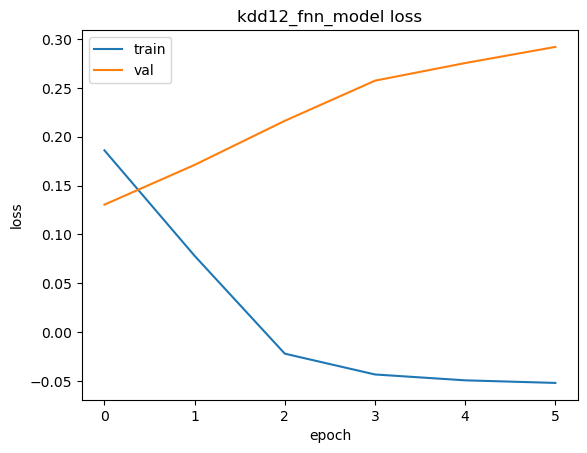

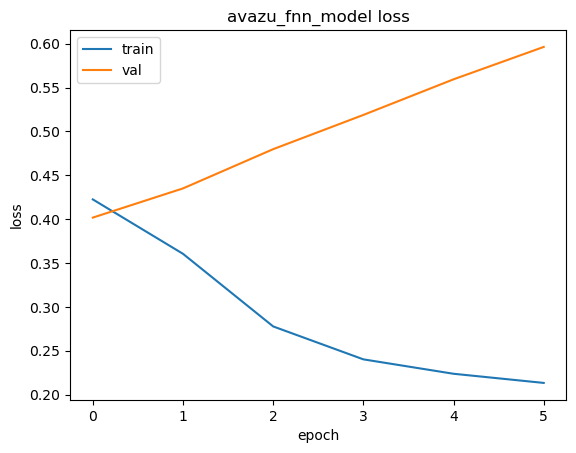

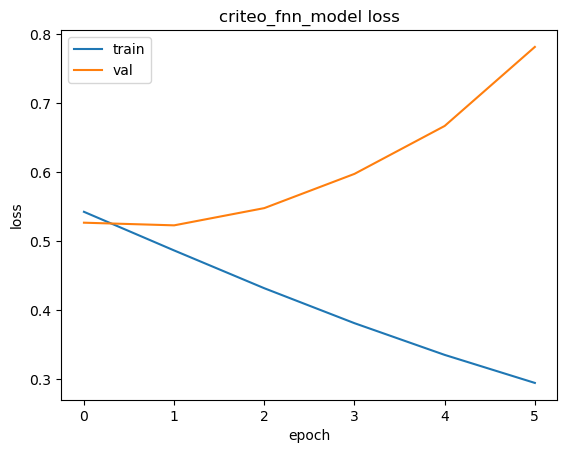

In [35]:
# Read in the history logs
kdd12_fnn_history = pd.read_csv('logs/kdd12_fnn.csv')
avazu_fnn_history = pd.read_csv('logs/avazu_fnn.csv')
criteo_fnn_history = pd.read_csv('logs/criteo_fnn.csv')

# Plot the training history
plt.plot(kdd12_fnn_history['binary_crossentropy'])
plt.plot(kdd12_fnn_history['val_binary_crossentropy'])
plt.title('kdd12_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_fnn_history['binary_crossentropy'])
plt.plot(avazu_fnn_history['val_binary_crossentropy'])
plt.title('avazu_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_fnn_history['binary_crossentropy'])
plt.plot(criteo_fnn_history['val_binary_crossentropy'])
plt.title('criteo_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
# Score the models
kdd12_fnn_score = kdd12_fnn_model.evaluate(kdd12_val_model_input, batch_size=256)
avazu_fnn_score = avazu_fnn_model.evaluate(avazu_val_model_input, batch_size=256)
criteo_fnn_score = criteo_fnn_model.evaluate(criteo_val_model_input, batch_size=256)

154/154 [==============================] - 67s 416ms/step - loss: 0.5299 - binary_crossentropy: 0.5270 - binary_accuracy: 0.7416 - precision: 0.6723 - recall: 0.3624


### Product Based Neural Networks

In [37]:
# Define the CSVLogger callbacks
kdd12_pnn_csvLogger = CSVLogger('logs/kdd12_pnn.csv')
avazu_pnn_csvLogger = CSVLogger('logs/avazu_pnn.csv')
criteo_pnn_csvLogger = CSVLogger('logs/criteo_pnn.csv')

In [38]:
# Define the model saving checkpoints
kdd12_pnn_modelCheckpoint = ModelCheckpoint('models/pnn/kdd12_pnn_model.keras',save_best_only=True)
avazu_pnn_modelCheckpoint = ModelCheckpoint('models/pnn/avazu_pnn_model.keras',save_best_only=True)
criteo_pnn_modelCheckpoint = ModelCheckpoint('models/pnn/criteo_pnn_model.keras',save_best_only=True)

In [39]:
# Compile the PNN models
kdd12_pnn_model = PNN(kdd12_dnn_feature_columns, task='binary')
kdd12_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

avazu_pnn_model = PNN(avazu_dnn_feature_columns, task='binary')
avazu_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

criteo_pnn_model = PNN(criteo_dnn_feature_columns, task='binary')
criteo_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [40]:
# Fit the models
kdd12_pnn_history = kdd12_pnn_model.fit(
    kdd12_train_model_input, 
    validation_data=kdd12_val_model_input,
    batch_size=256, 
    epochs=40, 
    callbacks=[kdd12_pnn_csvLogger,kdd12_pnn_modelCheckpoint,earlystopping]
)
avazu_pnn_history = avazu_pnn_model.fit(
    avazu_train_model_input,
    validation_data=avazu_val_model_input,
    batch_size=256, 
    epochs=40,
    callbacks=[avazu_pnn_csvLogger,avazu_pnn_modelCheckpoint,earlystopping]
)
criteo_pnn_history = criteo_pnn_model.fit(
    criteo_train_model_input,
    validation_data=criteo_val_model_input,
    batch_size=256, 
    epochs=40,
    callbacks=[criteo_pnn_csvLogger,criteo_pnn_modelCheckpoint,earlystopping]
)

Epoch 1/40
615/615 [==============================] - 134s 214ms/step - loss: 0.2318 - binary_crossentropy: 0.2310 - binary_accuracy: 0.9446 - precision: 0.6491 - recall: 0.2883 - val_loss: 0.1372 - val_binary_crossentropy: 0.1333 - val_binary_accuracy: 0.9550 - val_precision: 0.5593 - val_recall: 0.0188
Epoch 2/40
615/615 [==============================] - 134s 218ms/step - loss: 0.1085 - binary_crossentropy: 0.1033 - binary_accuracy: 0.9578 - precision: 0.5939 - recall: 0.2213 - val_loss: 0.1754 - val_binary_crossentropy: 0.1668 - val_binary_accuracy: 0.9458 - val_precision: 0.1724 - val_recall: 0.0512
Epoch 3/40
615/615 [==============================] - 133s 215ms/step - loss: 6.9958e-05 - binary_crossentropy: -0.0081 - binary_accuracy: 0.9825 - precision: 0.8745 - recall: 0.7585 - val_loss: 0.2518 - val_binary_crossentropy: 0.2453 - val_binary_accuracy: 0.9291 - val_precision: 0.1006 - val_recall: 0.0716
Epoch 4/40
615/615 [==============================] - 131s 213ms/step - loss:

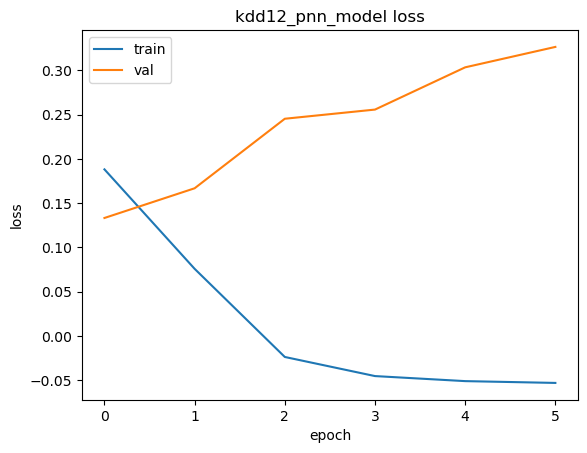

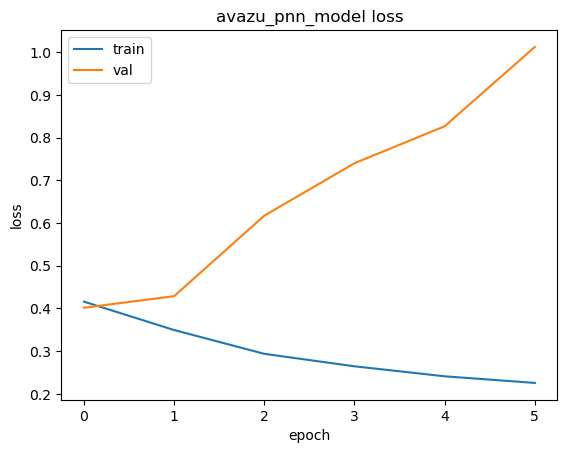

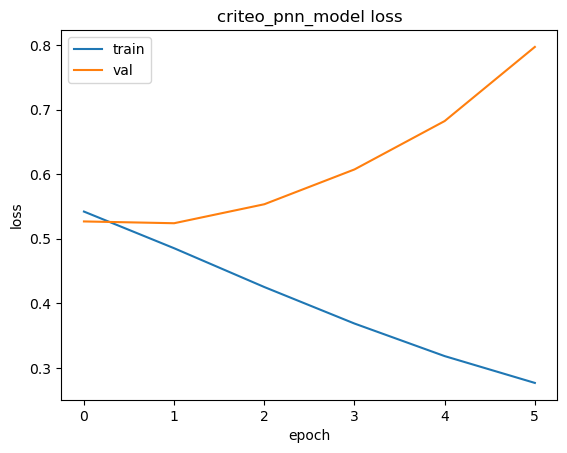

In [41]:
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_pnn.csv')
avazu_history = pd.read_csv('logs/avazu_pnn.csv')
criteo_history = pd.read_csv('logs/criteo_pnn.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Wide and Deep

In [42]:
# Compile the WDL models
kdd12_wdl_model = WDL(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
kdd12_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

avazu_wdl_model = WDL(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

criteo_wdl_model = WDL(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
criteo_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

In [43]:
# Define the CSVLogger callbacks
kdd12_wdl_csvLogger = CSVLogger('logs/kdd12_wdl.csv')
avazu_wdl_csvLogger = CSVLogger('logs/avazu_wdl.csv')
criteo_wdl_csvLogger = CSVLogger('logs/criteo_wdl.csv')

In [44]:
# Define the model saving checkpoints
kdd12_wdl_modelCheckpoint = ModelCheckpoint('models/wdl/kdd12_wdl_model.keras',save_best_only=True)
avazu_wdl_modelCheckpoint = ModelCheckpoint('models/wdl/avazu_wdl_model.keras',save_best_only=True)
criteo_wdl_modelCheckpoint = ModelCheckpoint('models/wdl/criteo_wdl_model.keras',save_best_only=True)

In [45]:
# Fit the Wide and Deep models
kdd12_wdl_history = kdd12_wdl_model.fit(
    kdd12_train_model_input, 
    validation_data=kdd12_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[kdd12_wdl_csvLogger,kdd12_wdl_modelCheckpoint,earlystopping]
)
avazu_wdl_history = avazu_wdl_model.fit(
    avazu_train_model_input, 
    validation_data=avazu_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[avazu_wdl_csvLogger,avazu_wdl_modelCheckpoint,earlystopping]
)
criteo_wdl_history = criteo_wdl_model.fit(
    criteo_train_model_input, 
    validation_data=criteo_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_wdl_csvLogger, criteo_wdl_modelCheckpoint,earlystopping]
)

Epoch 1/15
615/615 [==============================] - 165s 263ms/step - loss: 0.2626 - binary_crossentropy: 0.2617 - binary_accuracy: 0.9095 - precision: 0.5310 - recall: 0.3850 - val_loss: 0.1341 - val_binary_crossentropy: 0.1295 - val_binary_accuracy: 0.9547 - val_precision: 0.4615 - val_recall: 0.0171
Epoch 2/15
615/615 [==============================] - 162s 263ms/step - loss: 0.1062 - binary_crossentropy: 0.1003 - binary_accuracy: 0.9575 - precision: 0.5855 - recall: 0.2094 - val_loss: 0.1786 - val_binary_crossentropy: 0.1692 - val_binary_accuracy: 0.9439 - val_precision: 0.1677 - val_recall: 0.0603
Epoch 3/15
615/615 [==============================] - 163s 265ms/step - loss: 0.0016 - binary_crossentropy: -0.0072 - binary_accuracy: 0.9821 - precision: 0.8735 - recall: 0.7496 - val_loss: 0.2430 - val_binary_crossentropy: 0.2362 - val_binary_accuracy: 0.9324 - val_precision: 0.1169 - val_recall: 0.0762
Epoch 4/15
615/615 [==============================] - 164s 266ms/step - loss: -0.

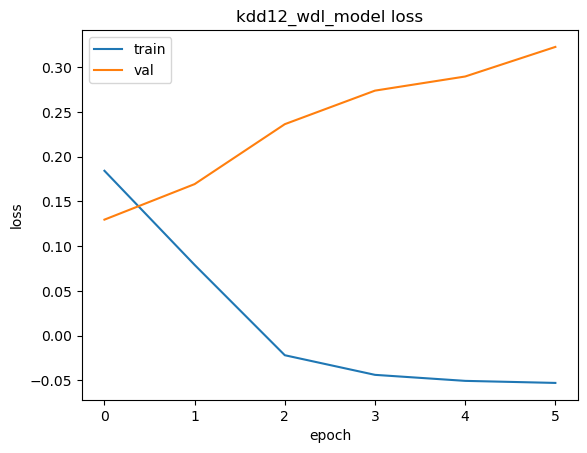

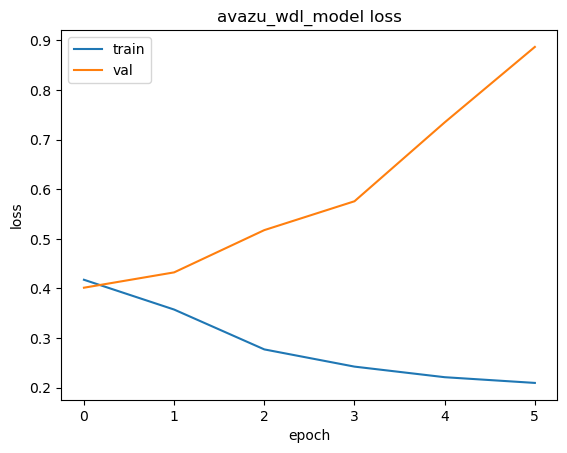

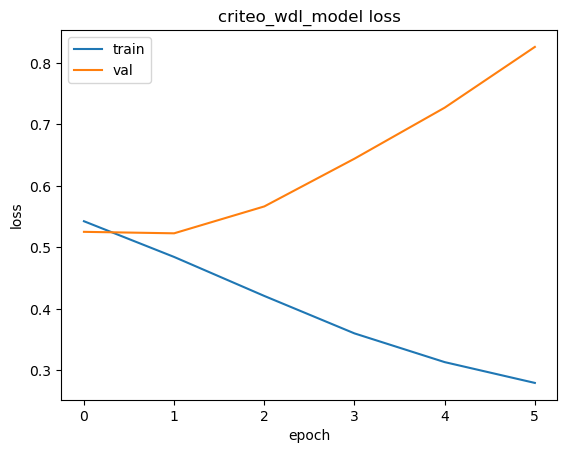

In [46]:
# Read in the history logs
kdd12_history = pd.read_csv('logs/kdd12_wdl.csv')
avazu_history = pd.read_csv('logs/avazu_wdl.csv')
criteo_history = pd.read_csv('logs/criteo_wdl.csv')

# Plot the training history
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### DeepFM

In [31]:
# Compile the DeepFM models
kdd12_dfm_model = DeepFM(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
kdd12_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

avazu_dfm_model = DeepFM(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

criteo_dfm_model = DeepFM(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
criteo_dfm_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [32]:
# Define the CSVLogger callbacks
kdd12_dfm_csvLogger = CSVLogger('logs/kdd12_dfm.csv')
avazu_dfm_csvLogger = CSVLogger('logs/avazu_dfm.csv')
criteo_dfm_csvLogger = CSVLogger('logs/criteo_dfm.csv')

In [33]:
# Define the model saving checkpoints
kdd12_dfm_modelCheckpoint = ModelCheckpoint('models/dfm/kdd12_dfm_model.keras',save_best_only=True)
avazu_dfm_modelCheckpoint = ModelCheckpoint('models/dfm/avazu_dfm_model.keras',save_best_only=True)
criteo_dfm_modelCheckpoint = ModelCheckpoint('models/dfm/criteo_dfm_model.keras',save_best_only=True)

In [35]:
# Fit the DeepFM models
kdd12_dfm_history = kdd12_dfm_model.fit(
    kdd12_train_model_input, 
    validation_data = kdd12_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[kdd12_dfm_csvLogger,kdd12_dfm_modelCheckpoint,earlystopping]
)
avazu_dfm_history = avazu_dfm_model.fit(
    avazu_train_model_input, 
    validation_data= avazu_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[avazu_dfm_csvLogger,avazu_dfm_modelCheckpoint,earlystopping]
)
criteo_dfm_history = criteo_dfm_model.fit(
    criteo_train_model_input, 
    validation_data=criteo_val_model_input, 
    batch_size=256, epochs=15,
    callbacks=[criteo_dfm_csvLogger,criteo_dfm_modelCheckpoint,earlystopping]
)

2024-08-03 19:39:06.143250: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-08-03 19:39:06.162593: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


Epoch 1/15
615/615 [==============================] - 163s 259ms/step - loss: 0.2300 - binary_crossentropy: 0.2291 - binary_accuracy: 0.9382 - precision: 0.0633 - recall: 0.0227 - val_loss: 0.1357 - val_binary_crossentropy: 0.1310 - val_binary_accuracy: 0.9546 - val_precision: 0.4308 - val_recall: 0.0159
Epoch 2/15
615/615 [==============================] - 158s 258ms/step - loss: 0.1073 - binary_crossentropy: 0.1014 - binary_accuracy: 0.9573 - precision: 0.5837 - recall: 0.2012 - val_loss: 0.1764 - val_binary_crossentropy: 0.1669 - val_binary_accuracy: 0.9445 - val_precision: 0.1833 - val_recall: 0.0648
Epoch 3/15
615/615 [==============================] - 159s 259ms/step - loss: 0.0030 - binary_crossentropy: -0.0060 - binary_accuracy: 0.9815 - precision: 0.8685 - recall: 0.7397 - val_loss: 0.2500 - val_binary_crossentropy: 0.2429 - val_binary_accuracy: 0.9303 - val_precision: 0.1158 - val_recall: 0.0819
Epoch 4/15
615/615 [==============================] - 161s 261ms/step - loss: -0.

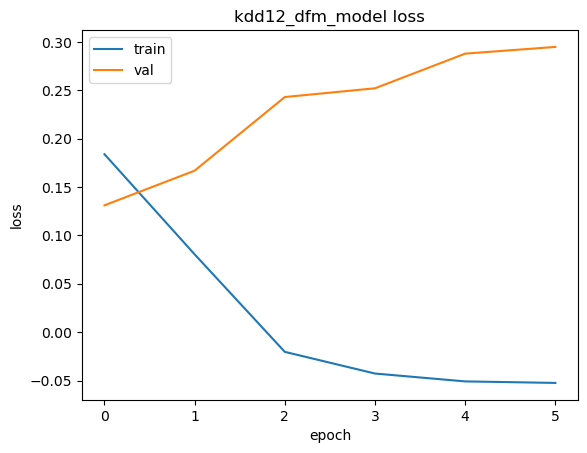

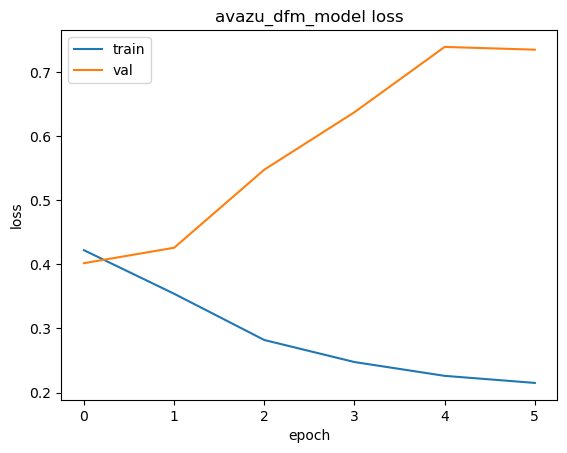

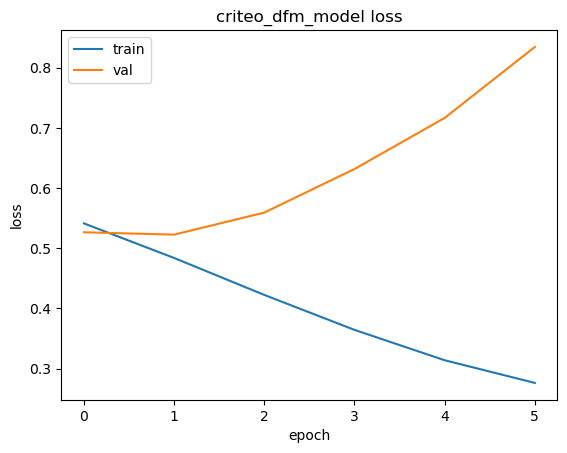

In [36]:
# Read in the history logs
kdd12_dfm_history = pd.read_csv('logs/kdd12_dfm.csv')
avazu_dfm_history = pd.read_csv('logs/avazu_dfm.csv')
criteo_dfm_history = pd.read_csv('logs/criteo_dfm.csv')

# Plot the training history
plt.plot(kdd12_dfm_history['binary_crossentropy'])
plt.plot(kdd12_dfm_history['val_binary_crossentropy'])
plt.title('kdd12_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_dfm_history['binary_crossentropy'])
plt.plot(avazu_dfm_history['val_binary_crossentropy'])
plt.title('avazu_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_dfm_history['binary_crossentropy'])
plt.plot(criteo_dfm_history['val_binary_crossentropy'])
plt.title('criteo_dfm_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Automatic Feature Interaction (AutoInt)

In [37]:
# Compile the AutoInt Models
kdd12_autoint_model = AutoInt(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
kdd12_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

avazu_autoint_model = AutoInt(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

criteo_autoint_model = AutoInt(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
criteo_autoint_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

In [38]:
# Define the AutoInt CSVLogger callbacks
kdd12_autoint_csvLogger = CSVLogger('logs/kdd12_autoint.csv')
avazu_autoint_csvLogger = CSVLogger('logs/avazu_autoint.csv')
criteo_autoint_csvLogger = CSVLogger('logs/criteo_autoint.csv')

In [39]:
# Define the model saving checkpoints
kdd12_autoint_modelCheckpoint = ModelCheckpoint('models/autoint/kdd12_autoint_model.keras',save_best_only=True)
avazu_autoint_modelCheckpoint = ModelCheckpoint('models/autoint/avazu_autoint_model.keras',save_best_only=True)
criteo_autoint_modelCheckpoint = ModelCheckpoint('models/autoint/criteo_autoint_model.keras',save_best_only=True)

In [40]:
# Fit the AutoInt models
kdd12_autoint_model.fit(
    kdd12_train_model_input, 
    validation_data= kdd12_val_model_input, 
    batch_size=256, 
    epochs=15, 
    callbacks=[kdd12_autoint_csvLogger, kdd12_autoint_modelCheckpoint,earlystopping]
)
avazu_autoint_model.fit(
    avazu_train_model_input,
    validation_data=avazu_val_model_input,
    batch_size=256, 
    epochs=15, 
    callbacks=[avazu_autoint_csvLogger, avazu_autoint_modelCheckpoint,earlystopping]
)
criteo_autoint_model.fit(
    criteo_train_model_input, 
    validation_data=criteo_val_model_input, 
    batch_size=256, 
    epochs=15,
    callbacks=[criteo_autoint_csvLogger,criteo_autoint_modelCheckpoint,earlystopping]
)

Epoch 1/15
615/615 [==============================] - 181s 288ms/step - loss: 0.2869 - binary_crossentropy: 0.2861 - binary_accuracy: 0.8977 - precision: 0.4718 - recall: 0.3948 - val_loss: 0.1354 - val_binary_crossentropy: 0.1313 - val_binary_accuracy: 0.9548 - val_precision: 0.4730 - val_recall: 0.0199
Epoch 2/15
615/615 [==============================] - 175s 284ms/step - loss: 0.0928 - binary_crossentropy: 0.0880 - binary_accuracy: 0.9587 - precision: 0.6192 - recall: 0.2488 - val_loss: 0.1700 - val_binary_crossentropy: 0.1630 - val_binary_accuracy: 0.9470 - val_precision: 0.1753 - val_recall: 0.0460
Epoch 3/15
615/615 [==============================] - 176s 286ms/step - loss: -0.0027 - binary_crossentropy: -0.0093 - binary_accuracy: 0.9814 - precision: 0.8620 - recall: 0.7409 - val_loss: 0.2496 - val_binary_crossentropy: 0.2444 - val_binary_accuracy: 0.9367 - val_precision: 0.1274 - val_recall: 0.0682
Epoch 4/15
615/615 [==============================] - 175s 284ms/step - loss: -0

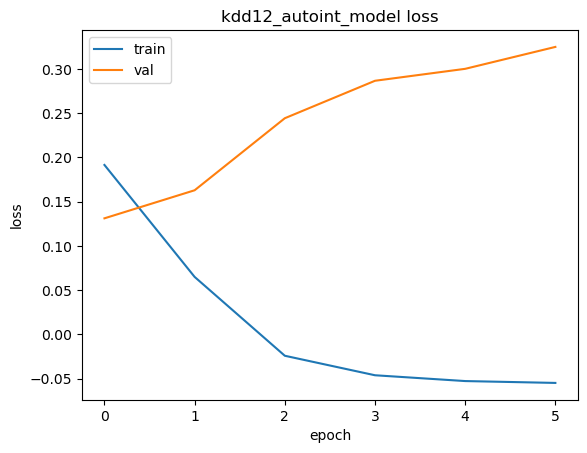

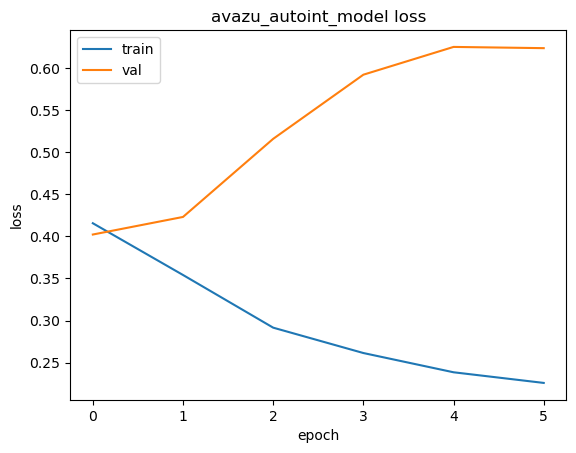

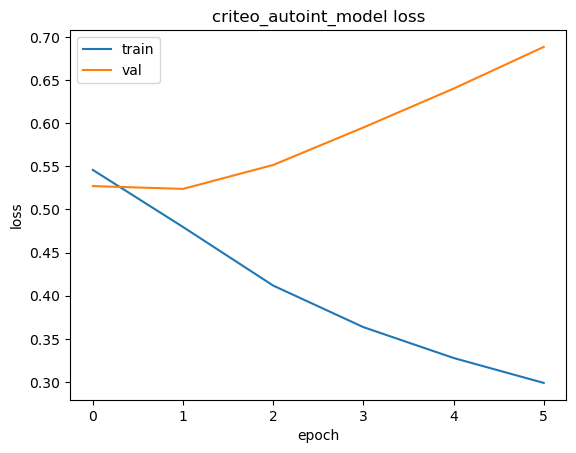

In [41]:
# Read in the history logs
kdd12_autoint_history = pd.read_csv('logs/kdd12_autoint.csv')
avazu_autoint_history = pd.read_csv('logs/avazu_autoint.csv')
criteo_autoint_history = pd.read_csv('logs/criteo_autoint.csv')

# Plot the training history
plt.plot(kdd12_autoint_history['binary_crossentropy'])
plt.plot(kdd12_autoint_history['val_binary_crossentropy'])
plt.title('kdd12_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_autoint_history['binary_crossentropy'])
plt.plot(avazu_autoint_history['val_binary_crossentropy'])
plt.title('avazu_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_autoint_history['binary_crossentropy'])
plt.plot(criteo_autoint_history['val_binary_crossentropy'])
plt.title('criteo_autoint_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Feature Generation by convolutional Neural Network - FGCNN

In [ ]:
# Compile the FGCNN models

#kdd12_fgcnn_model = FGCNN(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
#kdd12_fgcnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

avazu_fgcnn_model = FGCNN(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns,
    conv_kernel_width=[7,7,7,7],
    conv_filters=[14,16,18,20],
    new_maps=[3,3,3,3],
    dnn_hidden_units=[4096,2048,1024,512,1],# This was different
    task='binary'
)
avazu_fgcnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

criteo_fgcnn_model = FGCNN(
    avazu_linear_feature_columns, 
    avazu_dnn_feature_columns,
    conv_kernel_width=[9,9,9,9],
    conv_filters=[38,40,42,44],
    new_maps=[3,3,3,3],
    dnn_hidden_units=[4096,2048,1],# This was different
    task='binary'
)
criteo_fgcnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy','binary_accuracy',precision,recall], )

In [ ]:
# Define the AutoInt CSVLogger callbacks
kdd12_fgcnn_csvLogger = CSVLogger('logs/kdd12_fgcnn.csv')
avazu_fgcnn_csvLogger = CSVLogger('logs/avazu_fgcnn.csv')
criteo_fgcnn_csvLogger = CSVLogger('logs/criteo_fgcnn.csv')

In [ ]:
# Define the model saving checkpoints
kdd12_fgcnn_modelCheckpoint = ModelCheckpoint('models/fgcnn/kdd12_fgcnn_model.keras',save_best_only=True,save_weights_only=True)
avazu_fgcnn_modelCheckpoint = ModelCheckpoint('models/fgcnn/avazu_fgcnn_model.keras',save_best_only=True,save_weights_only=True)
criteo_fgcnn_modelCheckpoint = ModelCheckpoint('models/fgcnn/criteo_fgcnn_model.keras',save_best_only=True,save_weights_only=True)

In [ ]:
avazu_fgcnn_history = avazu_fgcnn_model.fit(
    avazu_train_model_input,
    validation_data=avazu_val_model_input,
    batch_size=256,
    epochs=15,
    callbacks=[avazu_fgcnn_csvLogger,avazu_fgcnn_modelCheckpoint,earlystopping]
)
criteo_fgcnn_history = criteo_fgcnn_model.fit(
    criteo_train_model_input,
    validation_data=criteo_val_model_input,
    batch_size=256,
    epochs=15,
    callbacks=[criteo_fgcnn_csvLogger,criteo_fgcnn_modelCheckpoint,earlystopping]
)

In [ ]:
# Read in the history logs
#kdd12_history = pd.read_csv('logs/kdd12_wdl.csv')
avazu_history = pd.read_csv('logs/avazu_fgcnn.csv')
criteo_history = pd.read_csv('logs/criteo_fgcnn.csv')

# Plot the training history
'''
plt.plot(kdd12_history['binary_crossentropy'])
plt.plot(kdd12_history['val_binary_crossentropy'])
plt.title('kdd12_wdl_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
'''

plt.plot(avazu_history['binary_crossentropy'])
plt.plot(avazu_history['val_binary_crossentropy'])
plt.title('avazu_fgcnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_history['binary_crossentropy'])
plt.plot(criteo_history['val_binary_crossentropy'])
plt.title('criteo_fgcnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()